# Data Exploration and Shift Detection in eICU Dataset 1

## 1. Environment Setup



In [20]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from pathlib import Path

# Plot aesthetics
sns.set(style="whitegrid")
%matplotlib inline



## 2. Load Diagnosis Data



In [21]:
# diagnosis dataset loaded here 
diagnosis_path = Path("eicu-collaborative-research-database-2.0/diagnosis.csv.gz")  
df_diag = pd.read_csv(diagnosis_path, compression="gzip")

# Check info
df_diag.info()
df_diag.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710672 entries, 0 to 2710671
Data columns (total 7 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   diagnosisid          int64 
 1   patientunitstayid    int64 
 2   activeupondischarge  bool  
 3   diagnosisoffset      int64 
 4   diagnosisstring      object
 5   icd9code             object
 6   diagnosispriority    object
dtypes: bool(1), int64(3), object(3)
memory usage: 126.7+ MB


,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,4222318,141168,False,72,cardiovascular|chest pain / ASHD|coronary arte...,"414.00, I25.10",Other
1,3370568,141168,True,118,cardiovascular|ventricular disorders|cardiomyo...,NaN,Other
2,4160941,141168,False,72,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
3,4103261,141168,True,118,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
4,3545241,141168,True,118,cardiovascular|ventricular disorders|congestiv...,"428.0, I50.9",Other


## 3. Merge Hospital or Unit Metadata




In [22]:
# load patient data with hospital/unit info
patient_path = Path("eicu-collaborative-research-database-2.0/patient.csv.gz") 
df_pat = pd.read_csv(patient_path, compression="gzip")

# relevant columns
df_pat = df_pat[['patientunitstayid', 'hospitalid', 'unittype']]

#check info
df_pat.info()
df_pat.head()

#mrging
df = df_diag.merge(df_pat, on='patientunitstayid', how='left')
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200859 entries, 0 to 200858
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   patientunitstayid  200859 non-null  int64 
 1   hospitalid         200859 non-null  int64 
 2   unittype           200859 non-null  object
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority,hospitalid,unittype
0,4222318,141168,False,72,cardiovascular|chest pain / ASHD|coronary arte...,"414.00, I25.10",Other,59,Med-Surg ICU
1,3370568,141168,True,118,cardiovascular|ventricular disorders|cardiomyo...,NaN,Other,59,Med-Surg ICU
2,4160941,141168,False,72,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other,59,Med-Surg ICU
3,4103261,141168,True,118,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other,59,Med-Surg ICU
4,3545241,141168,True,118,cardiovascular|ventricular disorders|congestiv...,"428.0, I50.9",Other,59,Med-Surg ICU


## 4. Define Shift Dimension




In [23]:
# Define the shift dimension
SHIFT_TYPE = "inter-hospital"  
if SHIFT_TYPE == "inter-hospital":
    shift_col = "hospitalid"
else:
    shift_col = "unittype"

# Show group sizes
df[shift_col].value_counts()


hospitalid
420    704221
188    114510
122     90314
142     82223
226     66816
        ...  
323        30
423        25
136        22
212        18
385         9
Name: count, Length: 207, dtype: int64

## 5. Select Feature to Evaluate Shift



In [24]:
# Encode categorical feature for testing
df = df.dropna(subset=['diagnosispriority'])  
df['diagnosispriority_encoded'] = pd.factorize(df['diagnosispriority'])[0]

feature = "diagnosispriority_encoded"

## 6. Visualize Feature Distribution by Group


/var/folders/5y/v983zg9s5mj989l04vv_c3lc0000gn/T/ipykernel_52353/704885923.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=shift_col)


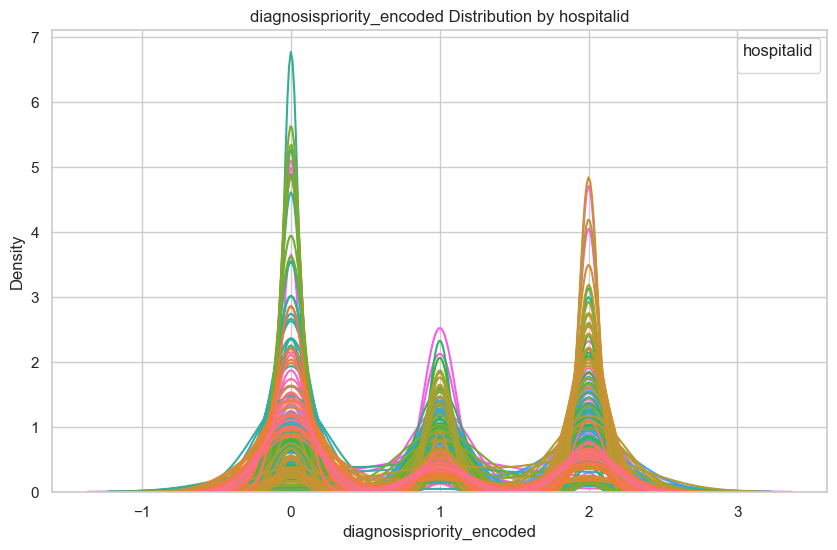

In [25]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x=feature, hue=df[shift_col].astype(str), common_norm=False)
plt.title(f"{feature} Distribution by {shift_col}")
plt.xlabel(feature)
plt.ylabel("Density")
plt.legend(title=shift_col)
plt.show()


## 7. Perform KS Test Between Two Groups

A low p-value (e.g., < 0.05) indicates significant distribution shift.


In [26]:
# Compare distributions between two groups
groups = df[shift_col].dropna().unique()[:2]
print(f"Comparing: {groups[0]} vs. {groups[1]}")

group1_data = df[df[shift_col] == groups[0]][feature].dropna()
group2_data = df[df[shift_col] == groups[1]][feature].dropna()

stat, p_value = ks_2samp(group1_data, group2_data)
print(f"KS Statistic = {stat:.4f}")
print(f"P-value = {p_value:.4f}")



Comparing: 59 vs. 66
KS Statistic = 0.0121
P-value = 0.9587


## 8. Save Train/Test Cohort Splits



In [27]:
# cohort splits based on shift
train_df = df[df[shift_col] == groups[0]]
test_df = df[df[shift_col] == groups[1]]

# Save for modeling
Path("cohorts").mkdir(exist_ok=True)
train_df.to_csv("cohorts/train.csv", index=False)
test_df.to_csv("cohorts/test.csv", index=False)

In [28]:
#making sample size 
# full cohort output from notebook 
df_train = pd.read_csv("cohorts/train.csv")
df_test = pd.read_csv("cohorts/test.csv")

# Random sample of 500 rows (for demo/testing)
sample_df_train = df_train.sample(n=500, random_state=42)
sample_df_test = df_test.sample(n=500, random_state=42)

# Save this
sample_df_train.to_csv("cohorts/train_inter_sample.csv", index=False)
sample_df_test.to_csv("cohorts/test_inter_sample.csv", index=False)